<a href="https://colab.research.google.com/github/merinjv/Handwriting-Recognition/blob/main/Project2_MerinVattathara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
!pip install import-ipynb
import import_ipynb
%cd "/content/drive/MyDrive/Colab Notebooks/Project2_370"

from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Project2_370


In [ ]:
!head -10 data/words.txt
np.random.seed(42)
tf.random.set_seed(42)

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad


In [ ]:
word_list=[]

words = open(f"./data/words.txt","r").readlines()

for line in words:
  if line[0]=="#":
    continue
  if line.split(" ")[1]!="err":
    word_list.append(line) #append the words that have no error

np.random.shuffle(word_list)

#Split Dataset

In [ ]:
index_split = int(0.95*len(word_list))
train_samples = word_list[:index_split]
test_samples = word_list[index_split:]

validation_split = int(0.5 * len(test_samples))
validation_samples = test_samples[:validation_split]
test_samples = test_samples[validation_split:]

assert len(word_list)==len(train_samples)+len(validation_samples)+len(test_samples)

In [ ]:
def image_paths(samples):
  paths=[]
  correct_samples=[]
  for(i,fileLine) in enumerate(samples):
    lineSplit = fileLine.strip()
    lineSplit = lineSplit.split(" ")
    imageName = lineSplit[0]
    firstC = imageName.split("-")[0]
    secondC = imageName.split("-")[1]
    os.chdir('/content/drive/MyDrive/Colab Notebooks/Project2_370')
    img_p = os.path.join('./data/words/',firstC,firstC+'-'+secondC,imageName+'.png')
    if not os.path.getsize(img_p):
      continue
    elif os.path.getsize(img_p):
      paths.append(img_p)
      correct_samples.append(fileLine.split("\n")[0])
  return paths,correct_samples

train_img_paths, train_labels = image_paths(train_samples)
validation_img_paths, validation_labels = image_paths(validation_samples)
test_img_paths, test_labels = image_paths(test_samples)

clean_labels = []
chars = set()
maxTextLen=0

for label in train_labels:
  label = label.split(" ")[-1].strip()
  for char in label:
    chars.add(char)

  maxTextLen = max(maxTextLen, len(label))
  clean_labels.append(label)

clean_labels[:5]

['sure', 'he', 'during', 'of', 'booty']

In [ ]:
def clean_label(labels):
  label_clean = []
  for label in labels:
    label = label.split(" ")[-1].strip()
    label_clean.append(label)
  return label_clean

validation_clean_labels = clean_label(validation_labels)
test_clean_labels = clean_label(test_labels)

AUTOTUNE=tf.data.AUTOTUNE

map_char_to_num = StringLookup(vocabulary=list(chars), mask_token=None)
map_num_to_char = StringLookup(vocabulary=map_char_to_num.get_vocabulary(), mask_token=None, invert=True)


def resize_img(image, imgSize):
    w, h = imgSize
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)
    padding_height = h - tf.shape(image)[0]
    padding_width = w - tf.shape(image)[1]

    if padding_height % 2 != 0:
        height = padding_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = padding_height // 2

    if padding_width % 2 != 0:
        width = padding_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = padding_width // 2

    image = tf.pad(image,paddings=[[pad_height_top, pad_height_bottom],[pad_width_left, pad_width_right],[0, 0],],)

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [ ]:

batch_size = 64
padding_tok = 99
image_width=128
image_height=32

def preprocessor(image_path, imgSize=(image_width,image_height)):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, 1)
  image = resize_img(image, imgSize)
  image = tf.cast(image, tf.float32)/255.0
  return image

def label_vector(label):
  label = map_char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
  length = tf.shape(label)[0]
  padding_a = maxTextLen - length
  label = tf.pad(label,paddings=[[0,padding_a]],constant_values=padding_tok)
  return label

def proccess_label(image_path, label):
  image = preprocessor(image_path)
  label = label_vector(label)
  feedDict={"image":image, "label":label}
  return feedDict

def dataset(image_path, labels):
  data_set = tf.data.Dataset.from_tensor_slices((image_path,labels)).map(proccess_label,num_parallel_calls=AUTOTUNE)
  return data_set.batch(batch_size).cache().prefetch(AUTOTUNE)

train_dataset = dataset(train_img_paths, clean_labels)
validation_dataset = dataset(validation_img_paths, validation_clean_labels)
test_dataset = dataset(test_img_paths, test_clean_labels)

print(train_dataset)


<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>


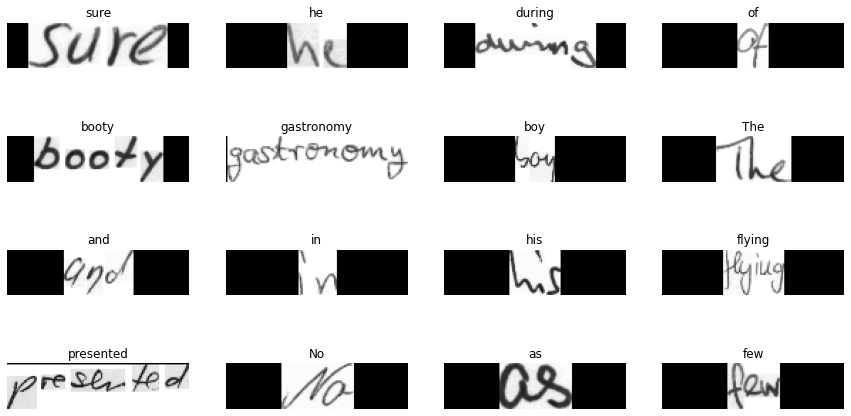

In [ ]:
for data in train_dataset.take(1):
  images,labels = data["image"],data["label"]
  _,x = plt.subplots(4,4,figsize=(15,8))

  for i in range(16):
    img=images[i]
    img=tf.image.flip_left_right(img)
    img=tf.transpose(img,perm=[1,0,2])
    img=(img*255.0).numpy().clip(0,255).astype(np.uint8)
    img = img[:, :, 0]
    label = labels[i]
    ind = tf.gather(label, tf.where(tf.math.not_equal(label,padding_tok)))
    label = tf.strings.reduce_join(map_num_to_char(ind))
    label = label.numpy().decode("UTF-8")

    x[i//4,i%4].imshow(img,cmap="gray")
    x[i//4,i%4].set_title(label)
    x[i//4,i%4].axis("off")
plt.show()

In [ ]:
class CTC(keras.layers.Layer):
  def __init__(self, name=None):
      super().__init__(name=name)
      self.loss = keras.backend.ctc_batch_cost

  def call(self, truth, pred):
    batchLen = tf.cast(tf.shape(truth)[0], dtype="int64")
    inputLen = tf.cast(tf.shape(pred)[1], dtype="int64")
    labelLen = tf.cast(tf.shape(truth)[1], dtype="int64")

    inputLen = inputLen*tf.ones(shape=(batchLen, 1), dtype="int64")
    labelLen = labelLen*tf.ones(shape=(batchLen, 1), dtype="int64")
    loss = self.loss(truth,pred,inputLen,labelLen)
    self.add_loss(loss)
    return pred

def build():
  input_img = keras.Input(shape=(image_width, image_height,1),name="image")
  labels = keras.layers.Input(name="label",shape=(None,))

  #first conv layer
  x = keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1",)(input_img)
  x = keras.layers.MaxPool2D((2,2), name="pool1")(x)

  #second conv layer
  x = keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2",)(x)
  x = keras.layers.MaxPool2D((2,2), name="pool2")(x)
  '''
  #third conv layer
  x = keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1",)(input_img)
  x = keras.layers.MaxPool2D((2,2), name="pool1")(x)
  '''

  newShape = ((image_width // 4), (image_height // 4) * 64)
  x=keras.layers.Reshape(target_shape=newShape, name="reshape")(x)
  x=keras.layers.Dense(64, activation="relu", name="dense1")(x)
  x=keras.layers.Dropout(0.2)(x)

  x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
  x = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

  x=keras.layers.Dense(len(map_char_to_num.get_vocabulary())+2, activation="softmax", name="dense2")(x)

  out = CTC(name="ctc_loss")(labels,x)
  model = keras.models.Model(inputs=[input_img, labels], outputs=out, name="handwriting_recognition")

  optimizer = keras.optimizers.Adam()
  model.compile(optimizer=optimizer)
  return model

model = build()
model.summary()

Model: "handwriting_recognition"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][

In [ ]:
validation_img=[]
validation_labels=[]

for batch in validation_dataset:
  validation_img.append(batch["image"])
  validation_labels.append(batch["label"])

def dist_change(labels, pred):
  sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)
  inputLength = np.ones(pred.shape[0])*pred.shape[1]
  pred_decode = keras.backend.ctc_decode(pred, input_length=inputLength, greedy=True)[0][0][:, :maxTextLen]
  sparse_pred = tf.cast(tf.sparse.from_dense(pred_decode), dtype=tf.int64)

  distance = tf.edit_distance(sparse_pred, sparse_labels, normalize=False)
  return tf.reduce_mean(distance)

class EditDistances(keras.callbacks.Callback):
  def __init__(self, pred_model):
    super().__init__()
    self.pred_model = pred_model

  def on_epoch_end(self,epoch,logs=None):
    edit_distances=[]
    for i in range(len(validation_img)):
      labels = validation_labels[i]
      preds = self.pred_model.predict(validation_img[i])
      edit_distances.append(dist_change(labels, preds).numpy())

In [ ]:
epochs = 35

pred_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)
dist_change_callback = EditDistances(pred_model)

history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[dist_change_callback],)


Epoch 1/35
1432/1432 [==============================] - 9496s 7s/step - loss: 13.5338 - val_loss: 11.3594
Epoch 2/35
1432/1432 [==============================] - 850s 593ms/step - loss: 10.3485 - val_loss: 8.4788
Epoch 3/35
1432/1432 [==============================] - 848s 592ms/step - loss: 7.8863 - val_loss: 5.9466
Epoch 4/35
  15/1432 [..............................] - ETA: 13:45 - loss: 6.5064

KeyboardInterrupt: ignored

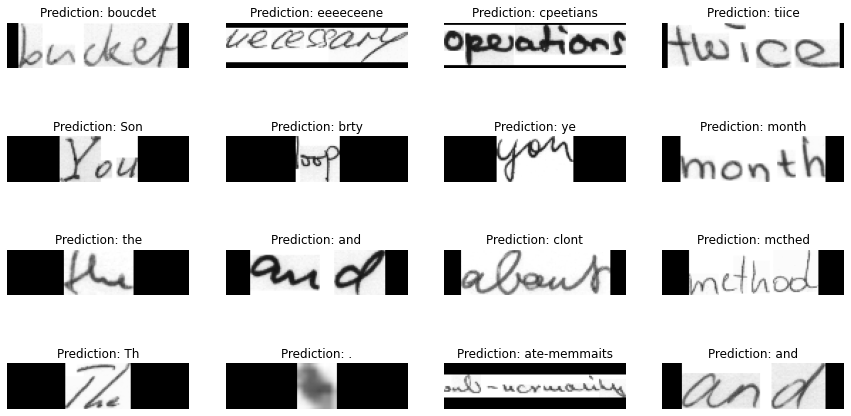

In [ ]:
def batch_pred(pred):
  input_length = np.ones(pred.shape[0])*pred.shape[1]
  res = keras.backend.ctc_decode(pred, input_length=input_length, greedy=True)[0][0][:, :maxTextLen]

  out_text = []
  for r in res:
    r = tf.gather(r,tf.where(tf.math.not_equal(r,-1)))
    r = tf.strings.reduce_join(map_num_to_char(r)).numpy().decode("utf-8")
    out_text.append(r)
  return out_text

for batch in test_dataset.take(1):
  batch_imgs = batch["image"]
  _,x = plt.subplots(4,4,figsize=(15,8))

  p = pred_model.predict(batch_imgs)
  pred_t = batch_pred(p)

  for i in range(16):
    img=batch_imgs[i]
    img=tf.image.flip_left_right(img)
    img=tf.transpose(img,perm=[1,0,2])
    img=(img*255.0).numpy().clip(0,255).astype(np.uint8)
    img = img[:, :, 0]
    title = f"Prediction: {pred_t[i]}"
    x[i//4,i%4].imshow(img,cmap="gray")
    x[i//4,i%4].set_title(title)
    x[i//4,i%4].axis("off")
plt.show()